In [1]:
import skfmm
import numpy as np
import scipy as sp
import KTCFwd
import KTCMeshing
import KTCScoring
import KTCRegularization
import KTCAux
import matplotlib.pyplot as plt
import glob
import dolfin as df
from skimage.segmentation import chan_vese

# Folders and difficulty level

In [2]:
df.set_log_level(40)

folder = 'app/'
inputFolder = folder + 'TrainingData'
truthFolder = folder + 'GroundTruths'

# Set difficulty
categoryNbr = 7

# Measurements

In [3]:
Nel = 32  # number of electrodes
z = (1e-6) * np.ones((Nel, 1))  # contact impedances
mat_dict = sp.io.loadmat(inputFolder + '/ref.mat') #load the reference data
Injref = mat_dict["Injref"] #current injections
Uelref = mat_dict["Uelref"] #measured voltages from water chamber
Mpat = mat_dict["Mpat"] #voltage measurement pattern
vincl = np.ones(((Nel - 1),76), dtype=bool) #which measurements to include in the inversion
rmind = np.arange(0,2 * (categoryNbr - 1),1) #electrodes whose data is removed

#remove measurements according to the difficulty level
for ii in range(0,75):
    for jj in rmind:
        if Injref[jj,ii]:
            vincl[:,ii] = 0
        vincl[jj,:] = 0

# Load mesh

In [4]:
# load premade finite element mesh (made using Gmsh, exported to Matlab and saved into a .mat file)
mat_dict_mesh = sp.io.loadmat(folder + 'Mesh_sparse.mat')
g = mat_dict_mesh['g'] #node coordinates
H = mat_dict_mesh['H'] #indices of nodes making up the triangular elements
elfaces = mat_dict_mesh['elfaces'][0].tolist() #indices of nodes making up the boundary electrodes

#Element structure
ElementT = mat_dict_mesh['Element']['Topology'].tolist()
for k in range(len(ElementT)):
    ElementT[k] = ElementT[k][0].flatten()
ElementE = mat_dict_mesh['ElementE'].tolist() #marks elements which are next to boundary electrodes
for k in range(len(ElementE)):
    if len(ElementE[k][0]) > 0:
        ElementE[k] = [ElementE[k][0][0][0], ElementE[k][0][0][1:len(ElementE[k][0][0])]]
    else:
        ElementE[k] = []

#Node structure
NodeC = mat_dict_mesh['Node']['Coordinate']
NodeE = mat_dict_mesh['Node']['ElementConnection'] #marks which elements a node belongs to
nodes = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC]
for k in range(NodeC.shape[0]):
    nodes[k].ElementConnection = NodeE[k][0].flatten()
elements = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT]
for k in range(len(ElementT)):
    elements[k].Electrode = ElementE[k]

#2nd order mesh data
H2 = mat_dict_mesh['H2']
g2 = mat_dict_mesh['g2']
elfaces2 = mat_dict_mesh['elfaces2'][0].tolist()
ElementT2 = mat_dict_mesh['Element2']['Topology']
ElementT2 = ElementT2.tolist()
for k in range(len(ElementT2)):
    ElementT2[k] = ElementT2[k][0].flatten()
ElementE2 = mat_dict_mesh['Element2E']
ElementE2 = ElementE2.tolist()
for k in range(len(ElementE2)):
    if len(ElementE2[k][0]) > 0:
        ElementE2[k] = [ElementE2[k][0][0][0], ElementE2[k][0][0][1:len(ElementE2[k][0][0])]]
    else:
        ElementE2[k] = []

NodeC2 = mat_dict_mesh['Node2']['Coordinate']  # ok
NodeE2 = mat_dict_mesh['Node2']['ElementConnection']  # ok
nodes2 = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC2]
for k in range(NodeC2.shape[0]):
    nodes2[k].ElementConnection = NodeE2[k][0].flatten()
elements2 = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT2]
for k in range(len(ElementT2)):
    elements2[k].Electrode = ElementE2[k]

Mesh = KTCMeshing.Mesh(H,g,elfaces,nodes,elements)
Mesh2 = KTCMeshing.Mesh(H2,g2,elfaces2,nodes2,elements2)

In [5]:
# Make Fenics mesh out of provided mesh

def make_Mesh(g,H):
    topological_dim = 2
    geometrical_dim = 2
    num_local_vertices = g.shape[0]
    num_global_vertices = num_local_vertices  # True if run in serial
    num_local_cells = H.shape[0]
    num_global_cells = num_local_cells

    # Create mesh object and open editor
    mesh = df.Mesh()
    editor = df.MeshEditor()
    editor.open(mesh, "triangle", topological_dim, geometrical_dim)
    editor.init_vertices_global(num_local_vertices, num_global_vertices)
    editor.init_cells_global(num_local_cells, num_global_cells)

    # Add verticess
    for i, coord in enumerate(g):
        editor.add_vertex(i, coord)

    # Add cells
    for i, cell in enumerate(H):
        editor.add_cell(i, cell)

    # Close editor
    editor.close(order = True)
    return mesh

mesh = make_Mesh(g,H)

# Define solver
Here we use the provided solver with some alterations. We use an inverse gamma noise model.

In [6]:
# Make starting guess:
# 1. Starting guess consists of three inclusions: design piecewise phi1 and phi2 such that this is possible
# 2. Make piecewise phi1 and phi2 to signed distance function with skfmm.distance
# 3. Make q = q1*((phi1>0)*(phi2>0)) + q2*((phi1>0)*(phi2<0)) + q3*((phi1<0)*(phi2>0)) + q4*((phi1<0)*(phi2<0))
pixwidth = 0.23 / 256
pixcenter_x = np.linspace(-0.115 + pixwidth / 2, 0.115 - pixwidth / 2 + pixwidth, 256)
pixcenter_y = pixcenter_x
X, Y = np.meshgrid(pixcenter_x, pixcenter_y)

size = 0.15
center1 = (-0.3*size,-0.3*size)
center2 = (0.3*size,-0.3*size)
center3 = (0*size,0.3*size)
r = 0.15*size

inclusion1 = (X-center1[0])**2 + (Y-center1[1])**2 < r**2
inclusion2 = (X-center2[0])**2 + (Y-center2[1])**2 < r**2
inclusion3 = (X-center3[0])**2 + (Y-center3[1])**2 < r**2

phi1_seg = -2.0*(inclusion1) - 2.0*(inclusion2) + 1.0
phi2_seg = -2.0*(inclusion2) - 2.0*(inclusion3) + 1.0

phi10 = skfmm.distance(phi1_seg, dx = 0.001).reshape((256**2,1))
phi20 = skfmm.distance(phi2_seg, dx = 0.001).reshape((256**2,1))


# Define solver
Here we use the provided solver with some alterations. We use an inverse gamma noise model.

In [7]:
# set up the forward solver for inversion
solver = KTCFwd.EITFEM(Mesh2,Mesh, Injref, Mpat, vincl)
# vincl needs to be flat
vincl = vincl.T.flatten()
# set up the noise model for inversion
noise_std1 = 0.05;  # standard deviation for first noise component (relative to each voltage measurement)
noise_std2 = 0.01;  # standard deviation for second noise component (relative to the largest voltage measurement)
solver.SetInvGamma(noise_std1, noise_std2, Uelref)
mask = np.array(vincl, bool)
noisematrix = 1e-7*solver.InvGamma_n[np.ix_(mask,mask)]
solver.noisematrix = noisematrix



# Fenics classes and spaces

In [8]:
# We primarily consider the Lagrange first order
V1 = df.FunctionSpace(mesh,'CG',1)
V02 = df.VectorFunctionSpace(mesh,'DG',0)

idx = df.dof_to_vertex_map(V1)
idx2 = df.vertex_to_dof_map(V1)


class qFunction(df.UserExpression):

    def __init__(self,phi,q1,q2,**kwargs):
        super().__init__(self,**kwargs)
        self.phi = phi
        self.q1 = q1
        self.q2 = q2

    def value_shape(self):
        return ()
    
    def eval(self,values,x):
        if self.phi(x) > 0:
            values[0] = self.q1
        else:
            values[0] = self.q2

class Denom(df.UserExpression):

    def __init__(self,gradf,delta,**kwargs):
        super().__init__(self,**kwargs)
        self.phigrad = gradf
        self.delta = delta

    def value_shape(self):
        return ()

    def eval(self,values,x):
        values[0] = 1/(((self.phigrad(x)[0])**2 + (self.phigrad(x)[1])**2+self.delta)**(1/2))
        #values[0] = self.phigrad(x)[0]

class MyTV:
    def __init__(self,q0fun,delta,**kwargs):
        #self.qfun = df.project(qFunction(phi,q1,q2),V1)

        self.q0fun = q0fun
        self.q0grad = df.project(df.grad(self.q0fun),V02)
        self.q0_denom = Denom(self.q0grad,delta)

        # operator
        self.p_trial = df.TrialFunction(V1)
        self.p_test = df.TestFunction(V1)

        #self.L_op = dl.assemble(ufl.inner(self.p_trial, self.p_test)*dx)
        #self.TV_op = df.assemble(self.q_denom*ufl.inner(df.grad(self.p_trial),df.grad(self.p_test))*dx)
        self.TV_op = df.assemble((self.q0_denom*df.inner(df.grad(self.p_trial),df.grad(self.p_test)))*df.dx)

    def eval_TV(self,qfun):
        return np.dot(self.TV_op * qfun.vector(),qfun.vector())

    def eval_grad(self,qfun):
        return 2*(self.TV_op * qfun.vector())[idx2]
    
    def update_op(self,q0fun):
        self.q0fun = q0fun
        self.q0grad = df.project(df.grad(self.q0fun),V02)
        self.q0_denom = Denom(self.q0grad,delta)
        self.TV_op = df.assemble((self.q0_denom*df.inner(df.grad(self.p_trial),df.grad(self.p_test)))*df.dx) 


# Optimization problem
We try tro minimize the functional of $q=q(\phi_1,\phi_2,q_1,q_2,q_3,q_4)$
$$F(\phi,q_1,q_2)=\frac{1}{2}\|U-\mathcal{G}(q)\|^2 + \beta \int_{\Omega} |\nabla q| \, dx.$$

The gradient takes the form
$$\frac{dF}{dq}=- \nabla_q \mathcal{G}(q)^T(U-\mathcal{G}(q)) - \beta \nabla \cdot (\frac{\nabla q}{|\nabla q|})$$
In case we use a weighted 2-norm (here I mean $q^T C q$ - this is the matrix Kuopio generate with inverse gamma distribution) and use "difference" data, we have
$$F(\phi,q_1,q_2)=\frac{1}{2}\|U-U_{\mathrm{ref}}-(\mathcal{G}(q)-\mathcal{G}(0.8))\|_{C}^2 + \beta \int_{\Omega} |\nabla q| \, dx.$$ 
Here we look at a $q$ with 4 classes $q=q(\phi_1,\phi_2,q_1,q_2,q_3,q_4)$ constructed by:
$$q = q_1(\phi_1>0, \phi_2>0) + q_2(\phi_1>0,\phi_2<0) + q_3(\phi_1<0,\phi_2>0) + q_4(\phi_1<0,\phi_2<0)$$
$$\frac{dF}{dq}=- \nabla_q \mathcal{G}(q)^TC[U-U_{\mathrm{ref}}-(\mathcal{G}(q)-\mathcal{G}(0.8))] - \beta \nabla \cdot (\frac{\nabla q}{|\nabla q|})$$ 
We assume $q_1=0.8$, $q_2=10^{-3}$, $q_3=10$, $q_4=10^3$. Note
$$\frac{dq}{d\phi_1} = \delta(\phi_1)[q_1H(\phi_2)+q_2(1-H(\phi_2))-q_3H(\phi_2)-q_4(1-H(\phi_2))]$$
$$\frac{dq}{d\phi_2} = \delta(\phi_2)[q_1H(\phi_1)-q_2H(\phi_1)+q_3(1-H(\phi_1))-q_4(1-H(\phi_1))]$$

We then perform a gradient descent updating in the directions
$$\frac{dF}{d\phi_1}=\frac{dF}{dq} \frac{dq}{d\phi_1}.$$
$$\frac{dF}{d\phi_2}=\frac{dF}{dq} \frac{dq}{d\phi_2}.$$
We approximate $\delta(\phi)$ with 
$$\delta_\epsilon(\phi)=\frac{\epsilon}{\pi(\phi^2+\epsilon^2)},$$
and $H(\phi)$ with
$$H_\delta(\phi) = \frac{1}{\pi}\mathrm{tan}^{-1}(\frac{\phi}{\delta})+1/2$$

In [9]:
## Jasper regularization
radius = np.max(np.linalg.norm(Mesh.g, axis = 1))
m = Mesh.g.shape[0]
num_el =  32 - (2*categoryNbr - 1)
electrodes = np.zeros((num_el, 2))
angle = 2*np.pi/Nel
for i in range(num_el):
    electrodes[i] = radius*np.array([np.sin(i*angle), np.cos(i*angle)])


D = np.zeros(m)
for i in range(m):
    v = Mesh.g[i]
    dist = np.zeros(num_el)
    for k, e in enumerate(electrodes):
        dist[k] = np.linalg.norm(v - e)
    D[i] = (np.linalg.norm(dist, ord = 3)**3)*np.linalg.norm(v)**4

D = np.diag(D)


In [10]:
def compute_functional2(q,solver,Umeas,Umeas_ref,z,beta,idx,TV):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Solve forward problem
    Usim = solver.SolveForward2(q, z)

    # Compute TV
    R = TV.eval_TV(qfun)

    disp = np.array((Umeas-Umeas_ref)-(Usim-solver.Uref))

    #return solver.noisematrix @ disp
    #print(disp.T)
    #print((solver.noisematrix@disp).T)
    F = 0.5 * disp.T * solver.noisematrix @ disp + beta*R
    return F[0][0]
    #return 0.5*np.inner(disp.T,(solver.noisematrix@disp).T) + beta*R
    #return 0.5*np.dot(disp.T,solver.noisematrix@disp)+ beta*R

def compute_functional3(q,solver,Umeas,Umeas_ref,z,beta,idx,TV,zeta,D):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Solve forward problem
    Usim = solver.SolveForward2(q, z)

    # Compute TV
    R = TV.eval_TV(qfun)

    disp = np.array((Umeas-Umeas_ref)-(Usim-solver.Uref))

    #return solver.noisematrix @ disp
    #print(disp.T)
    #print((solver.noisematrix@disp).T)
    F = 0.5 * disp.T * solver.noisematrix @ disp + beta*R + zeta*q.T*D@q
    return F[0][0]
    #return 0.5*np.inner(disp.T,(solver.noisematrix@disp).T) + beta*R
    #return 0.5*np.dot(disp.T,solver.noisematrix@disp)+ beta*R

def compute_functional2_given_disp(disp,q,solver,Umeas,Umeas_ref,beta,idx,TV):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Compute TV
    R = TV.eval_TV(qfun)

    #return solver.noisematrix @ disp
    #print(disp.T)
    #print((solver.noisematrix@disp).T)
    F = 0.5 * np.array(disp).T * solver.noisematrix @ disp + beta*R
    return F[0][0]

def compute_functional3_given_disp(disp,q,solver,Umeas,Umeas_ref,beta,idx,TV,zeta,D):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Compute TV
    R = TV.eval_TV(qfun)

    #return solver.noisematrix @ disp
    #print(disp.T)
    #print((solver.noisematrix@disp).T)
    F = 0.5 * np.array(disp).T * solver.noisematrix @ disp + beta*R + zeta*q.T@D@q
    return F[0][0]


def find_direction2_dFdq(q,solver,Umeas,Umeas_ref,z,beta,idx,TV,eps):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Forward map
    Usim = solver.SolveForward2(q, z)

    # Jacobian
    J = solver.Jacobian(q, z)

    # TV regularization direction
    tvdir = TV.eval_grad(qfun)

    disp = (Umeas-Umeas_ref)-(Usim-solver.Uref)
    dataterm = np.array(- J.T @ solver.noisematrix @ (disp)).reshape(-1)

    # Approximate delta function
    #delta_eps = eps/(3.14159*(phi**2+eps**2))

    # dFdq
    dFdq = dataterm + beta*tvdir

    # Full direction
    #dF = (q2-q1)*dFdq * delta_eps

    return dFdq, disp

def find_direction3_dFdq(q,solver,Umeas,Umeas_ref,z,beta,idx,TV,eps,zeta,D):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Forward map
    Usim = solver.SolveForward2(q, z)

    # Jacobian
    J = solver.Jacobian(q, z)

    # TV regularization direction
    tvdir = TV.eval_grad(qfun)
    Ddir = 2*D@q

    disp = (Umeas-Umeas_ref)-(Usim-solver.Uref)
    dataterm = np.array(- J.T @ solver.noisematrix @ (disp)).reshape(-1)

    # Approximate delta function
    #delta_eps = eps/(3.14159*(phi**2+eps**2))

    # dFdq
    dFdq = dataterm + beta*tvdir + zeta*Ddir

    # Full direction
    #dF = (q2-q1)*dFdq * delta_eps

    return dFdq, disp

def find_direction_dqdphi(phi1,phi2,q1,q2,q3,q4,eps):
    # Approximate delta function
    delta_phi1 = eps/(3.14159*(phi1**2+eps**2))
    delta_phi2 = eps/(3.14159*(phi2**2+eps**2))
    H_phi1 = 1/3.141592 * np.arctan(phi1/eps)+1/2
    H_phi2 = 1/3.141592 * np.arctan(phi2/eps)+1/2

    dqdphi1 = q1*H_phi2 + q2*(1-H_phi2) - q3*H_phi2 - q4*(1-H_phi2)
    dqdphi2 = q1*H_phi1 - q2*H_phi1 + q3*(1-H_phi1) - q4*(1-H_phi1)

    dqdphi1 = delta_phi1*dqdphi1
    dqdphi2 = delta_phi2*dqdphi2

    return dqdphi1, dqdphi2

# Reinitialization of distance function
We need a stable way of reinitializing the level set function so that it is close to a distance function. This is crucial for the numerical stability of the algorithm.

In [11]:
# Reinitialization algorithm based on Runge-Kutta4 discretization in time direction

def reinitRK(l,idx,Niter,dt,eps,alpha):
    #phifun.vector().set_local(l[idx])

    # Set the initial value
    phi = df.TrialFunction(V1)
    phi0 = df.Function(V1)
    w = df.TestFunction(V1)
    phi1 = df.Function(V1)
    phi2 = df.Function(V1)
    phi3 = df.Function(V1)
    phi4 = df.Function(V1)
    phi_new = df.Function(V1)

    k = df.Constant(dt) # Time step Python
    phi0.vector().set_local(l[idx]) # Initial value

    epsdf = df.Constant(eps) # Interface thickness
    alphadf = df.Constant (alpha) # Numerical diffusion parameter
    sixth = df.Constant(dt/6.0)

    sign_term = phi0/ df.sqrt(phi0**2 + df.inner(df.grad(phi0),df.grad(phi0))* epsdf**2)

    a = phi*w*df.dx

    # For the heat equation:
    L1heat = - alpha * df.inner(df.grad(phi0),df.grad(w)) * df.dx
    L2heat = - alpha * df.inner(df.grad(phi0 + k/2 * phi1),df.grad(w)) * df.dx
    L3heat = - alpha * df.inner(df.grad(phi0 + k/2 * phi2),df.grad(w)) * df.dx
    L4heat = - alpha * df.inner(df.grad(phi0 + k * phi3),df.grad(w)) * df.dx


    # For the Eikonal equation:
    L1eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 ) , df.grad ( phi0 ))))* w*df.dx
    L2eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 + k/2 * phi1 ) , df.grad ( phi0 + k/2 * phi1 ))))* w*df.dx
    L3eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 + k/2 * phi2 ) , df.grad ( phi0 + k/2 * phi2 ))))* w*df.dx
    L4eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 + k * phi3 ) , df.grad ( phi0 + k * phi3 ))))* w*df.dx


    L1 = L1heat + L1eik
    L2 = L2heat + L2eik
    L3 = L3heat + L3eik
    L4 = L4heat + L4eik

    # Boundary condition
    bc = []
    # Flag setup
    Ei = 1e10 ; E_old = 1e10
    cont = 0; num_steps = 10



    for i in range(Niter):
        
        df.solve (a == L1, phi1, bc)
        df.solve (a == L2, phi2, bc)
        df.solve (a == L3, phi3, bc)
        df.solve (a == L4, phi4, bc)


        phi_new = phi0 + sixth * (phi1 + 2*phi2 + 2*phi3 + phi4)


        # Euclidean norm
        error = ((( phi_new - phi0 )/k )**2)* df.dx
        E = df.sqrt (abs( df.assemble ( error )))
        

        # Divergence flag
        if ( E_old < E ):
            fail = 1
            print("* Diverges at reinit *", cont)
            break
        
        cont +=1
        E_old = E

        phi0.assign(phi_new)

    return phi0

# Data 
We try to load data from test 4

/tmp/ipykernel_37309/4098198376.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi1_img_fun.vector().set_local(phi10[idx_img])
/tmp/ipykernel_37309/4098198376.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi2_img_fun.vector().set_local(phi20[idx_img])


Loading Agrad


/opt/conda/envs/env/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/conda/envs/env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


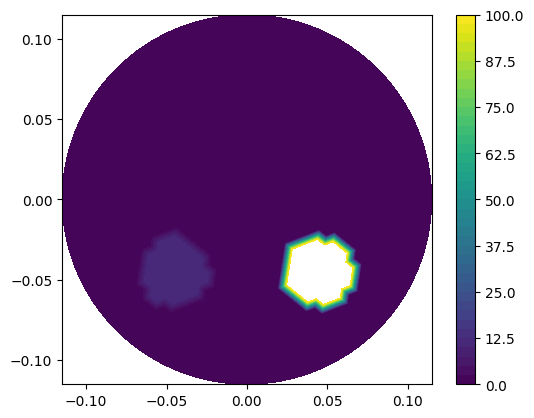

In [12]:
# Mesh used for image
Nimg = 256
himg = 0.23 / Nimg
mimg = -0.115 + himg
mesh_img = df.RectangleMesh(df.Point(mimg,mimg), df.Point(-mimg,-mimg), Nimg-1,Nimg-1)
V_img = df.FunctionSpace(mesh_img,'CG',1)
idx_img = df.dof_to_vertex_map(V_img)
idx_img2 = df.vertex_to_dof_map(V_img)

# Load data
mat_file = glob.glob(inputFolder + '/data4.mat')
mat_dict = sp.io.loadmat(mat_file[0])
Uel = mat_dict["Uel"]
# Load ground truth and plot
ground_truth = glob.glob(truthFolder + '/true4.mat')
truth_dict = sp.io.loadmat(ground_truth[0])

# Represent start guess phi1 and phi2 on mesh
#q0_img = 20*np.flipud(truth_dict["truth"]).reshape(256**2,1)+0.8
phi1_img_fun = df.Function(V_img)
phi2_img_fun = df.Function(V_img)

phi1_img_fun.vector().set_local(phi10[idx_img])
phi2_img_fun.vector().set_local(phi20[idx_img])

phi1_img_fun.set_allow_extrapolation(True)
phi2_img_fun.set_allow_extrapolation(True)

phi1_fun = df.interpolate(phi1_img_fun,V1)
phi2_fun = df.interpolate(phi2_img_fun,V1)

# Extract vector of values in the right order
phi10 = phi1_fun.vector().get_local()[idx2]
phi20 = phi2_fun.vector().get_local()[idx2] 

q1 = 0.8
q2 = 1e-2
q3 = 10
q4 = 100

q = q1*((phi10>0)*(phi20>0)) + q2*((phi10>0)*(phi20<=0)) + q3*((phi10<=0)*(phi20>0)) + q4*((phi10<=0)*(phi20<=0))
#q0 = q

# We cast it as an CG1 function
qfun = df.Function(V1)
qfun.vector().set_local(q[idx])

p = df.plot(qfun)
plt.colorbar(p)

# Initialize solver and jacobian and reference data
Uel_sim = solver.SolveForward2(q, z)
JJ = solver.Jacobian(0.8+0*q,z)

1.43380689910611

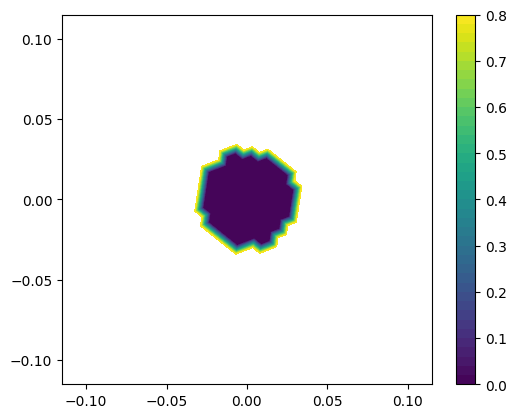

In [13]:
# Starting guess
r1 = 0.02
r2 = 0.03
k1 = np.linalg.norm(g-[0,0], axis=1)
k2 = np.linalg.norm(g-[0,0.05], axis=1)

phi10 = k1-r2
phi20 = k2-r1
phi20 = 2+g[:,0]

# Initialize level set function
phi1k = phi10
phi1 = phi1k
phi2k = phi20
phi2 = phi2k

# Initial level set functions
#phi1k = phi10
#phi2k = phi20

q1 = 0.8
q2 = 0.01
q3 = 0.01
q4 = 0.01

# Starting guess becomes this:
q = q1*((phi1k>0)*(phi2k>0)) + q2*((phi1k>0)*(phi2k<=0)) + q3*((phi1k<=0)*(phi2k>0)) + q4*((phi1k<=0)*(phi2k<=0))
q0 = q

# We cast it as an CG1 function
qfun = df.Function(V1)
qfun.vector().set_local(q[idx])

# Parameters and data for algorithm
# Load reference data
mat_file = glob.glob(inputFolder + '/ref.mat')
mat_dictref = sp.io.loadmat(mat_file[0])
Umeas_ref = mat_dictref["Uelref"]

# Slice data corresponding to difficulty level
Umeas = Uel[vincl]
Umeas_ref = Umeas_ref[vincl]

# Reinitialization parameters
alpha_dif = 9*1e-4 # diffusion parameter
dt = 1.5*1e-4
Ninit = 50

# TV Regularization parameter
beta = 1e-12
zeta = 25

# TV Smoothness parameter in lagged diffusion (should be around average length of element)
delta = 1e-3

# Smoothness parameter for delta approximation and sign function in reinitializationi (should be small)
eps = 1e-3
# Step size
alpha = 0.05
# Number of iterations
Miter = 200

# Backtracking line search
#tau = 0.5
#c = 0.025

# Initialize Total variation object
TV = MyTV(qfun,delta)

# Initial functional value
#F0 = compute_functional2(q,solver,Umeas,Umeas_ref,z,beta,idx,TV)
time_since_last1 = 0
time_since_last2 = 0

p = df.plot(qfun)
plt.colorbar(p)
compute_functional3(q,solver,Umeas,Umeas_ref,z,beta,idx,TV,1e5,D)

In [14]:
# Iterate!

j = 0
for i in range(Miter):

    # Take step in phi1 direction
    dFdq, disp = find_direction3_dFdq(q,solver,Umeas,Umeas_ref,z,beta,idx,TV,eps,zeta,D)
    dqdphi1,dqdphi2 = find_direction_dqdphi(phi1k,phi2k,q1,q2,q3,q4,eps)
    phi1k = phi1k - alpha * (dFdq*dqdphi1)
    # Form q 
    q = q1*((phi1k>0)*(phi2k>0)) + q2*((phi1k>0)*(phi2k<=0)) + q3*((phi1k<=0)*(phi2k>0)) + q4*((phi1k<=0)*(phi2k<=0))

    # Take step in phi2 direction
    dFdq, disp = find_direction3_dFdq(q,solver,Umeas,Umeas_ref,z,beta,idx,TV,eps,zeta,D)
    dqdphi1,dqdphi2 = find_direction_dqdphi(phi1k,phi2k,q1,q2,q3,q4,eps)
    phi2k = phi2k - alpha * (dFdq*dqdphi2)
    print(np.min(phi2k))
    # Form q 
    q = q1*((phi1k>0)*(phi2k>0)) + q2*((phi1k>0)*(phi2k<=0)) + q3*((phi1k<=0)*(phi2k>0)) + q4*((phi1k<=0)*(phi2k<=0))


    qfun.vector().set_local(q[idx])
    F = compute_functional3_given_disp(disp,q,solver,Umeas,Umeas_ref,beta,idx,TV,zeta,D)
    #F = compute_functional2(q,solver,Umeas,Umeas_ref,z,beta,idx,TV)
    
    if i == 5:
        alpha = alpha/2
        print("Updating stepsize =", alpha)
    if i == 20:
        alpha = alpha/2
        print("Updating stepsize =", alpha)
    if i == 50:
        alpha = alpha/2 
        print("Updating stepsize =", alpha)
    if i == 100:
        alpha = alpha/2
        print("Updating stepsize =", alpha)
    # Backtracking line search 
    #tt = c * np.linalg.norm(dF)**2
    #j = 0
    #while(F0-F < alpha*tt and F0-F > 1e-5):
    #    j = j+1
    #    alpha = tau*alpha
    #    phik_new = phik_new + alpha * dF
    #    q = q1*(phik_new>0) + q2*(phik_new<=0)  
    #    qfun.vector().set_local(q[idx])
    #    F = compute_functional2(q,solver,Umeas,Umeas_ref,z,beta,idx,TV)

    # Take a step of length alpha in that direction
    print("Iteration =", i, "::: Loss =", F)
    #phik = phik + alpha * dF
    #q = q1*(phik>0) + q2*(phik<=0)  
    #F0 = F
    

    # if phi1 is changed more than 10% we reinitialize and recompute TV object
    if np.linalg.norm(phi1k-phi1)/np.linalg.norm(phi1) > 0.1 or time_since_last1 >= 10:
        print("Reinitializing phi1")
        phi1k = reinitRK(phi1k,idx,Ninit,dt,eps,alpha_dif).vector().get_local()[idx2]
        phi1 = phi1k.copy()
        q = q1*((phi1k>0)*(phi2k>0)) + q2*((phi1k>0)*(phi2k<=0)) + q3*((phi1k<=0)*(phi2k>0)) + q4*((phi1k<=0)*(phi2k<=0))
        qfun.vector().set_local(q[idx])
        TV.update_op(qfun)
        time_since_last1 = 0

    if np.linalg.norm(phi2k-phi2)/np.linalg.norm(phi2) > 0.1 or time_since_last2 >= 10:
        print("Reinitializing phi2")
        phi2k = reinitRK(phi2k,idx,Ninit,dt,eps,alpha_dif).vector().get_local()[idx2]
        phi2 = phi2k.copy()
        q = q1*((phi1k>0)*(phi2k>0)) + q2*((phi1k>0)*(phi2k<=0)) + q3*((phi1k<=0)*(phi2k>0)) + q4*((phi1k<=0)*(phi2k<=0))
        qfun.vector().set_local(q[idx])
        TV.update_op(qfun)
        time_since_last2 = 0
    
    time_since_last1 += 1
    time_since_last2 += 1

1.8849994723894359
Iteration = 0 ::: Loss = [[0.34196176]]


KeyboardInterrupt: 

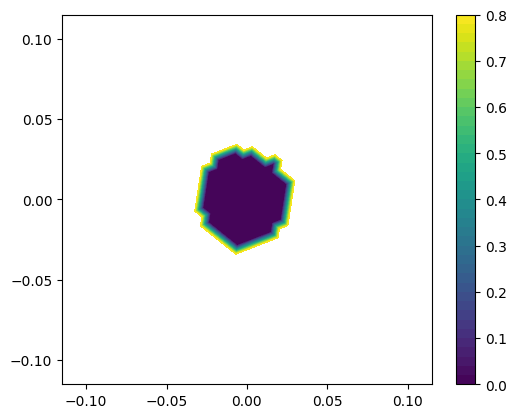

In [15]:
q = q1*((phi1k>0)*(phi2k>0)) + q2*((phi1k>0)*(phi2k<=0)) + q3*((phi1k<=0)*(phi2k>0)) + q4*((phi1k<=0)*(phi2k<=0))

qfun.vector().set_local(q[idx])
p = df.plot(qfun)
plt.colorbar(p)

* Diverges at reinit * 5


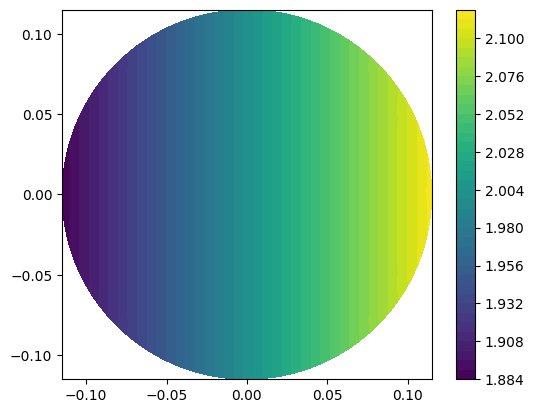

In [16]:
phi1k1 = reinitRK(phi1k,idx,Ninit,2.0*1e-4,eps,8.0*1e-4).vector().get_local()[idx2]
phi2k2 = reinitRK(phi2k,idx,Ninit,2.0*1e-4,eps,8.0*1e-4).vector().get_local()[idx2]
#phi = phik2
#q = q1*((phi1k>0)*(phi2k>0)) + q2*((phi1k>0)*(phi2k<=0)) + q3*((phi1k<=0)*(phi2k>0)) + q4*((phi1k<=0)*(phi2k<=0))

qfun.vector().set_local(phi2k2[idx])

p = df.plot(qfun)
plt.colorbar(p)

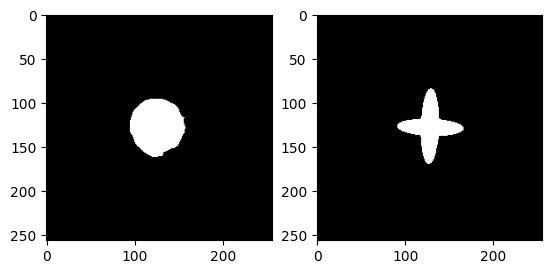

In [17]:
phi1_grid = KTCAux.interpolateRecoToPixGrid(phi1k, Mesh)
phi2_grid = KTCAux.interpolateRecoToPixGrid(phi2k, Mesh)
q = 0*((phi1_grid>0)*(phi2_grid>0)) + 2*((phi1_grid>0)*(phi2_grid<0)) + 1*((phi1_grid<0)*(phi2_grid>0)) + 1*((phi1_grid<0)*(phi2_grid<0))
#q[q==0.] = 
#q[q<=q1] = 0

#mesh_img.coordinates()
#q[q<q1] = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(q, cmap="gray")
ax[1].imshow(truth_dict["truth"], cmap="gray")

In [3]:
Nel = 32  # number of electrodes
z = (1e-6) * np.ones((Nel, 1))  # contact impedances
mat_dict = sp.io.loadmat('app/TrainingData'+ '/ref.mat') #load the reference data
Injref = mat_dict["Injref"] #current injections
Uelref = mat_dict["Uelref"] #measured voltages from water chamber
Mpat = mat_dict["Mpat"] #voltage measurement pattern
vincl = np.ones(((Nel - 1),76), dtype=bool) #which measurements to include in the inversion
rmind = np.arange(0,2 * (categoryNbr - 1),1) #electrodes whose data is removed


#remove measurements according to the difficulty level
for ii in range(0,75):
    for jj in rmind:
        if Injref[jj,ii]:
            vincl[:,ii] = 0
        vincl[jj,:] = 0

# load premade finite element mesh (made using Gmsh, exported to Matlab and saved into a .mat file)
mat_dict_mesh = sp.io.loadmat('app/Mesh_sparse.mat')
g = mat_dict_mesh['g'] #node coordinates
H = mat_dict_mesh['H'] #indices of nodes making up the triangular elements
elfaces = mat_dict_mesh['elfaces'][0].tolist() #indices of nodes making up the boundary electrodes



#Element structure
ElementT = mat_dict_mesh['Element']['Topology'].tolist()
for k in range(len(ElementT)):
    ElementT[k] = ElementT[k][0].flatten()
ElementE = mat_dict_mesh['ElementE'].tolist() #marks elements which are next to boundary electrodes
for k in range(len(ElementE)):
    if len(ElementE[k][0]) > 0:
        ElementE[k] = [ElementE[k][0][0][0], ElementE[k][0][0][1:len(ElementE[k][0][0])]]
    else:
        ElementE[k] = []

#Node structure
NodeC = mat_dict_mesh['Node']['Coordinate']
NodeE = mat_dict_mesh['Node']['ElementConnection'] #marks which elements a node belongs to
nodes = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC]
for k in range(NodeC.shape[0]):
    nodes[k].ElementConnection = NodeE[k][0].flatten()
elements = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT]
for k in range(len(ElementT)):
    elements[k].Electrode = ElementE[k]

#2nd order mesh data
H2 = mat_dict_mesh['H2']
g2 = mat_dict_mesh['g2']
elfaces2 = mat_dict_mesh['elfaces2'][0].tolist()
ElementT2 = mat_dict_mesh['Element2']['Topology']
ElementT2 = ElementT2.tolist()
for k in range(len(ElementT2)):
    ElementT2[k] = ElementT2[k][0].flatten()
ElementE2 = mat_dict_mesh['Element2E']
ElementE2 = ElementE2.tolist()
for k in range(len(ElementE2)):
    if len(ElementE2[k][0]) > 0:
        ElementE2[k] = [ElementE2[k][0][0][0], ElementE2[k][0][0][1:len(ElementE2[k][0][0])]]
    else:
        ElementE2[k] = []

NodeC2 = mat_dict_mesh['Node2']['Coordinate']  # ok
NodeE2 = mat_dict_mesh['Node2']['ElementConnection']  # ok
nodes2 = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC2]
for k in range(NodeC2.shape[0]):
    nodes2[k].ElementConnection = NodeE2[k][0].flatten()
elements2 = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT2]
for k in range(len(ElementT2)):
    elements2[k].Electrode = ElementE2[k]

Mesh = KTCMeshing.Mesh(H,g,elfaces,nodes,elements)
Mesh2 = KTCMeshing.Mesh(H2,g2,elfaces2,nodes2,elements2)

# print(f'Nodes in inversion 1st order mesh: {len(Mesh.g)}')

sigma0 = np.ones((len(Mesh.g), 1)) #linearization point
corrlength = 1 * 0.115 #used in the prior
var_sigma = 0.05 ** 2 #prior variance
mean_sigma = sigma0
smprior = KTCRegularization.SMPrior(Mesh.g, corrlength, var_sigma, mean_sigma)

# set up the forward solver for inversion
solver = KTCFwd.EITFEM(Mesh2, Mesh, Injref, Mpat, vincl)
# Initialize solver and jacobian and reference data
q0 = 0.8 + 0*g[:,0]
Uel_sim = solver.SolveForward2(q0, z)
JJ = solver.Jacobian(0.8+0*q0,z)

vincl = vincl.T.flatten()

# set up the noise model for inversion
noise_std1 = 0.05;  # standard deviation for first noise component (relative to each voltage measurement)
noise_std2 = 0.01;  # standard deviation for second noise component (relative to the largest voltage measurement)
solver.SetInvGamma(noise_std1, noise_std2, Uelref)

# Get a list of .mat files in the input folder
mat_files = sorted(glob.glob(inputFolder + '/data*.mat'))

mat_dict2 = sp.io.loadmat(mat_files[1])
Inj = mat_dict2["Inj"]
Uel = mat_dict2["Uel"]
Mpat = mat_dict2["Mpat"]
deltaU = Uel - Uelref
#############################  Changed code
reg1 = 0.75
reg2 = 1e15
smprior.L = reg1*smprior.L
radius = np.max(np.linalg.norm(Mesh.g, axis = 1))
m = Mesh.g.shape[0]
num_el =  32 - (2*categoryNbr - 1)
electrodes = np.zeros((num_el, 2))
angle = 2*np.pi/Nel
for i in range(num_el):
    electrodes[i] = radius*np.array([np.sin(i*angle), np.cos(i*angle)])


D = np.zeros(m)
for i in range(m):
    v = Mesh.g[i]
    dist = np.zeros(num_el)
    for k, e in enumerate(electrodes):
        dist[k] = np.linalg.norm(v - e)
    D[i] = (np.linalg.norm(dist, ord = 3)**3)*np.linalg.norm(v)**4

D = np.diag(D)

mask = np.array(vincl, bool) # Mask the removed electrodes

deltaU = Uel - Uelref
J = solver.Jacobian(sigma0, z)
deltareco = np.linalg.solve(J.T @ solver.InvGamma_n[np.ix_(mask,mask)] @ J + smprior.L.T @ smprior.L + reg2*D.T@D,
                            J.T @ solver.InvGamma_n[np.ix_(mask,mask)] @ deltaU[vincl])

# interpolate the reconstruction into a pixel image
deltareco_pixgrid = KTCAux.interpolateRecoToPixGrid(deltareco, Mesh)

# Do Chan-Vese segmentation
mu = np.mean(deltareco_pixgrid)
# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(abs(deltareco_pixgrid), mu=0.1, lambda1=1, lambda2=1, tol=1e-6,
            max_num_iter=1000, dt=2.5, init_level_set="checkerboard",
            extended_output=True)

labeled_array, num_features = sp.ndimage.label(cv[0])
# Initialize a list to store masks for each region
region_masks = []

# Loop through each labeled region
deltareco_pixgrid_segmented = np.zeros((256,256))

for label in range(1, num_features + 1):
    # Create a mask for the current region
    region_mask = labeled_array == label
    region_masks.append(region_mask)
    if np.mean(deltareco_pixgrid[region_mask]) < mu:
        deltareco_pixgrid_segmented[region_mask] = 1
    else:
        deltareco_pixgrid_segmented[region_mask] = 2

###################################  End of changed code
reconstruction = deltareco_pixgrid_segmented

Loading Agrad


/opt/conda/envs/env/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/conda/envs/env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


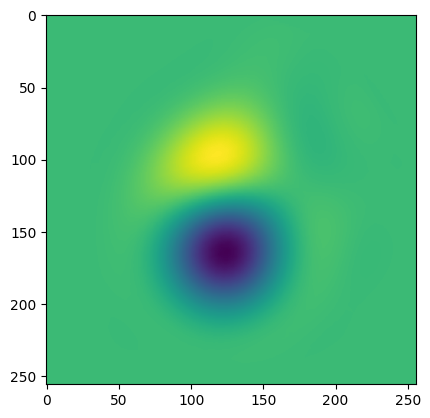

In [5]:
plt.imshow(deltareco_pixgrid)

In [45]:
Uel.shape

(2356, 1)

In [9]:
categoryNbr

7